# MODEL 

In [6]:
import sqlite3 as lite
import math
import time
import sys
import json
import pandas as pd
import os
import ftplib
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

fdir = os.path.abspath(os.path.dirname('__file__'))
start_time = time.time()



In [44]:
# Set to True to use a nice sample db
sample_data = True

In [45]:
time_format = "%Y-%m-%dT%H:%M"


k = 0.12
scale_m = 1.91
scale_a = 0.234
delay = np.timedelta64(60, 'm') # 60 minutes

def f(x):
    return math.exp(k*x)
def g(x):
    return (scale_m * x) + scale_a
def f_inv(x):
    return math.log(x) / k
def g_inv(x):
    return (x - scale_a) / scale_m

In [46]:
# Get current time rounded down to nearest 15 minutes
current_time = time.time()
current_time = current_time - (current_time % (15*60))
current_time = pd.to_datetime(current_time, unit='s')

if sample_data:
    current_time = pd.to_datetime('2016-11-21 18:30:00') 

print current_time

2016-11-21 18:30:00


# Load data from sql database into pandas df

In [47]:
if sample_data:
    database = os.path.join(fdir, '../sample_data.db')
else:
    database = os.path.join(fdir, '../data.db')
river = 'dart'
limit = 200
con = lite.connect(database)
cur = con.cursor()
query = """
        SELECT timestamp, rain, level, forecast 
            from {river}
        ORDER BY timestamp DESC
        LIMIT {limit}
    """
cur.execute(query.format(river=river, limit=limit))
result = cur.fetchall()
df = pd.DataFrame(result, columns=['timestamp', 'cum_rain', 'level', 'forecast'])
df.head()

,timestamp,cum_rain,level,forecast
0,2016-11-23T03:00,NaN,NaN,0.000000
1,2016-11-23T00:00,NaN,NaN,0.000000
2,2016-11-22T21:00,NaN,NaN,0.006510
3,2016-11-22T18:00,NaN,NaN,0.000000
4,2016-11-22T15:00,NaN,NaN,0.070833


# Set index to timestamp column as object

In [48]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df = df.sort_index()
df.head()

,cum_rain,level,forecast
timestamp,,,
2016-11-19 19:15:00,NaN,0.578,NaN
2016-11-19 19:30:00,8.6,0.592,NaN
2016-11-19 19:45:00,NaN,0.605,NaN
2016-11-19 20:00:00,10.2,0.621,NaN
2016-11-19 20:15:00,NaN,0.639,NaN


# Pre-model checks

In [49]:

# Check that there is a level update in df
if len(df[df.level.notnull()]) == 0:
    print 'No level updates'
    
# Check that there is a row for now or past now
if len(df[df.index >= current_time]) == 0:
    print 'Not enough data'


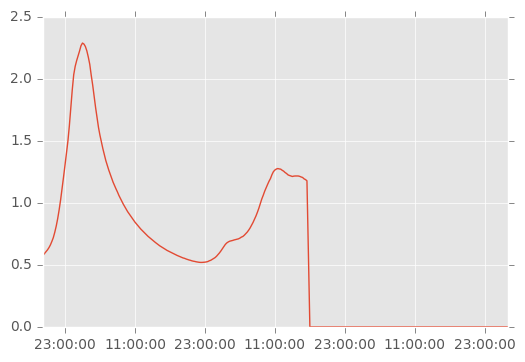

In [50]:
plt.plot(df.level.fillna(0))

# Calculate important timestamps

In [51]:
latest_level_time = max(df.index[df.level.notnull()])

print latest_level_time
latest_level = df.loc[latest_level_time].level
print latest_level

2016-11-21 16:30:00
1.178


In [52]:
latest_rain_time = max(df.index[df.cum_rain.notnull()])

print latest_rain_time

2016-11-21 20:00:00


# Fill in missing timestamps

In [53]:
min_time = min(df.index)
max_time = max(df.index)
rng = pd.date_range(min_time, max_time, freq='15Min')
df = df.reindex(rng)


# Cumulative rain -> actual rain

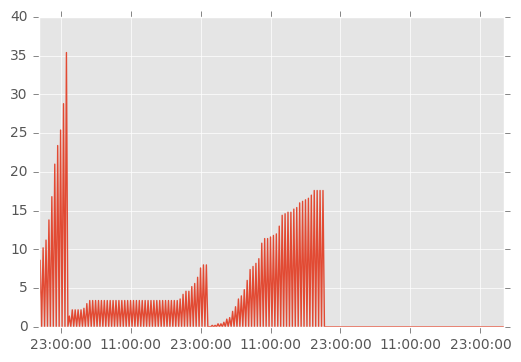

In [54]:
plt.plot(df.cum_rain.fillna(0))

In [55]:
df['rain'] = df['cum_rain'].diff(periods=2)
df.loc[df['rain'] < 0, 'rain'] = 0 
# interpolate and div 2 to get actual rain every 15 min
df['rain'] = df['rain'].interpolate()
df['rain'] = df['rain'] / 2

# multiply by 4 to get rain rate per hour
df['rain'] = df['rain'] * 2


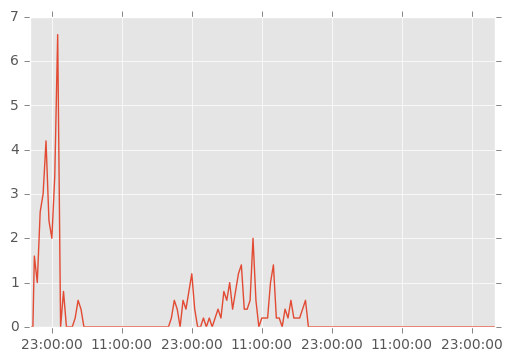

In [56]:
plt.plot(df['rain'].fillna(0))

# Interpolate forecast

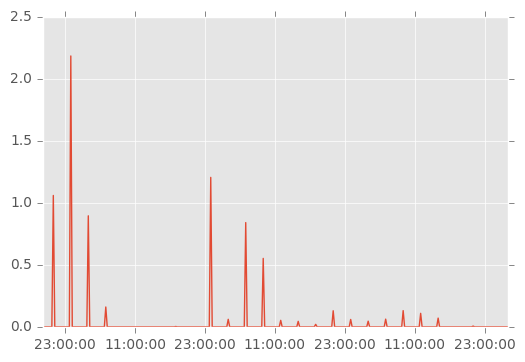

In [57]:
# Input forecast data is in mm/hour
plt.plot(df.forecast.fillna(0))

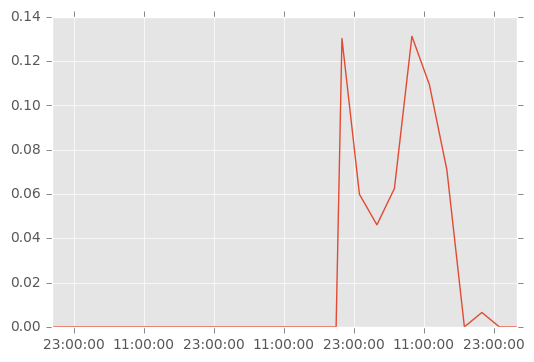

In [58]:
# Remove forecast before latest_rain_time
df.loc[min_time:latest_rain_time, 'forecast'] = None

# Set forecast to rain at latest_rain_time
df.loc[latest_rain_time].forecast = df.loc[latest_rain_time].rain

df['forecast'] = df['forecast'].interpolate()

plt.plot(df.forecast.fillna(0))

# Run model

In [59]:
df['model_rain'] = df['forecast'].fillna(0) + df['rain'].fillna(0)
df['storage'] = np.nan
df['predict'] = np.nan

# Calculate initial storage
init_storage = f_inv(g_inv(latest_level))
df.loc[latest_level_time, 'storage'] = init_storage

# Run iteration for indexes > latest_level_update
storage = init_storage
df_model = df[(df.index > pd.Timestamp(latest_level_time))]
for i,r in df_model.iterrows():
    rain = df.loc[i - delay, 'model_rain']
    predict = g(f(storage))
    storage = storage + rain - f(storage)
    df.loc[i, 'storage'] = storage
    df.loc[i, 'predict'] = predict

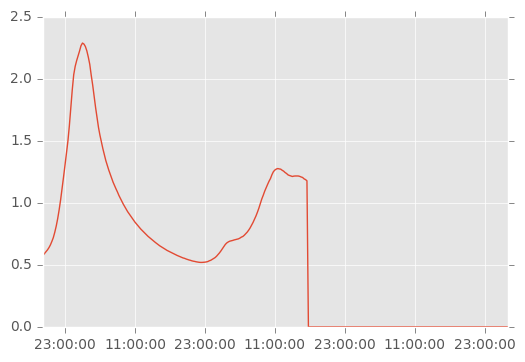

In [60]:
plt.plot(df.level.fillna(0))

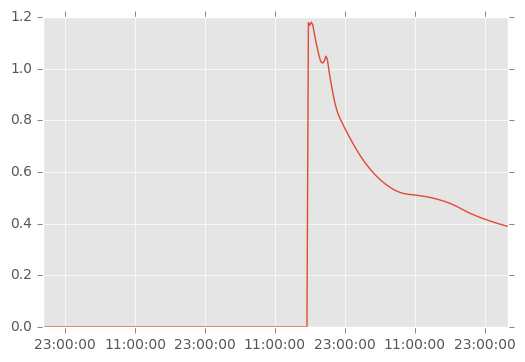

In [61]:
plt.plot(df.predict.fillna(0))

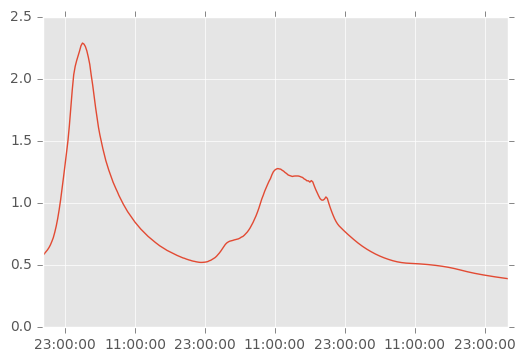

In [62]:
plt.plot(df.level.fillna(0) + df.predict.fillna(0))

# Create export dictionary

* Round model_rain, level and predict
* Get current time rounded down to nearest 15 minutes
* create output dict with the following properties
    * values
    * current_time
    * current_level
    * text
    * next_up if in next hour

In [63]:
# Round export columns
df = df.round({'level': 3, 'predict': 3, 'model_rain' : 1})

In [64]:

try:
    current_row = df.loc[pd.to_datetime(current_time, unit='s')]
    current_level = current_row['level']
    if np.isnan(current_level):
        current_level = current_row['predict']
except KeyError:
    print "Can't find row in df that matches current time: "+ time.strftime(time_format, time.gmtime(current_time))
    current_level = None
    
print current_level

1.057


In [65]:

df.timestamp = df.index
df = df.where((pd.notnull(df)), None)
timestamp_vals = [timestmp.value / 1000 for timestmp in df.index.tolist()]
rain_vals = df.model_rain.tolist()
level_vals = df.level.tolist()
predict_vals = df.predict.tolist()
values = []
for n in range(0, len(timestamp_vals)):
    values.append({'timestamp' : timestamp_vals[n], 'rain' : rain_vals[n], 'level' : level_vals[n], 'predict' : predict_vals[n]})


In [66]:
if current_level > 1.5:
    text = "THE DART IS MASSIVE"
elif current_level > 0.7:
    text = 'YES'
else:
    next_up = df[(df.index > current_time) & (df.index < current_time + delay) & (df.predict > 0.2)].index.min()
    if pd.isnull(next_up):
        text = 'NO'
    else:
        text = "THE DART WILL BE UP SHORTLY"    
print text

YES


In [67]:
output = {}       
output['current_time'] = current_time.value / 1000
output['current_level'] = current_level 
output['text'] = text
output['values'] = values


# Write export to json

In [70]:
filename = os.path.join(fdir, 'dart.json')
with open(filename, 'w') as f:
    json.dump(output, f)


In [69]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 874.854226828 seconds ---
